In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [3]:
data = "../Alzheimers-classification/data/AugmentedAlzheimerDataset/"
image_dir = Path(data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)


In [4]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(data).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [5]:
image_df

,Filepath,Label
0,..\Alzheimers-classification\data\AugmentedAlz...,MildDemented
1,..\Alzheimers-classification\data\AugmentedAlz...,MildDemented
2,..\Alzheimers-classification\data\AugmentedAlz...,MildDemented
3,..\Alzheimers-classification\data\AugmentedAlz...,MildDemented
4,..\Alzheimers-classification\data\AugmentedAlz...,MildDemented
...,...,...
67963,..\Alzheimers-classification\data\AugmentedAlz...,VeryMildDemented
67964,..\Alzheimers-classification\data\AugmentedAlz...,VeryMildDemented
67965,..\Alzheimers-classification\data\AugmentedAlz...,VeryMildDemented
67966,..\Alzheimers-classification\data\AugmentedAlz...,VeryMildDemented


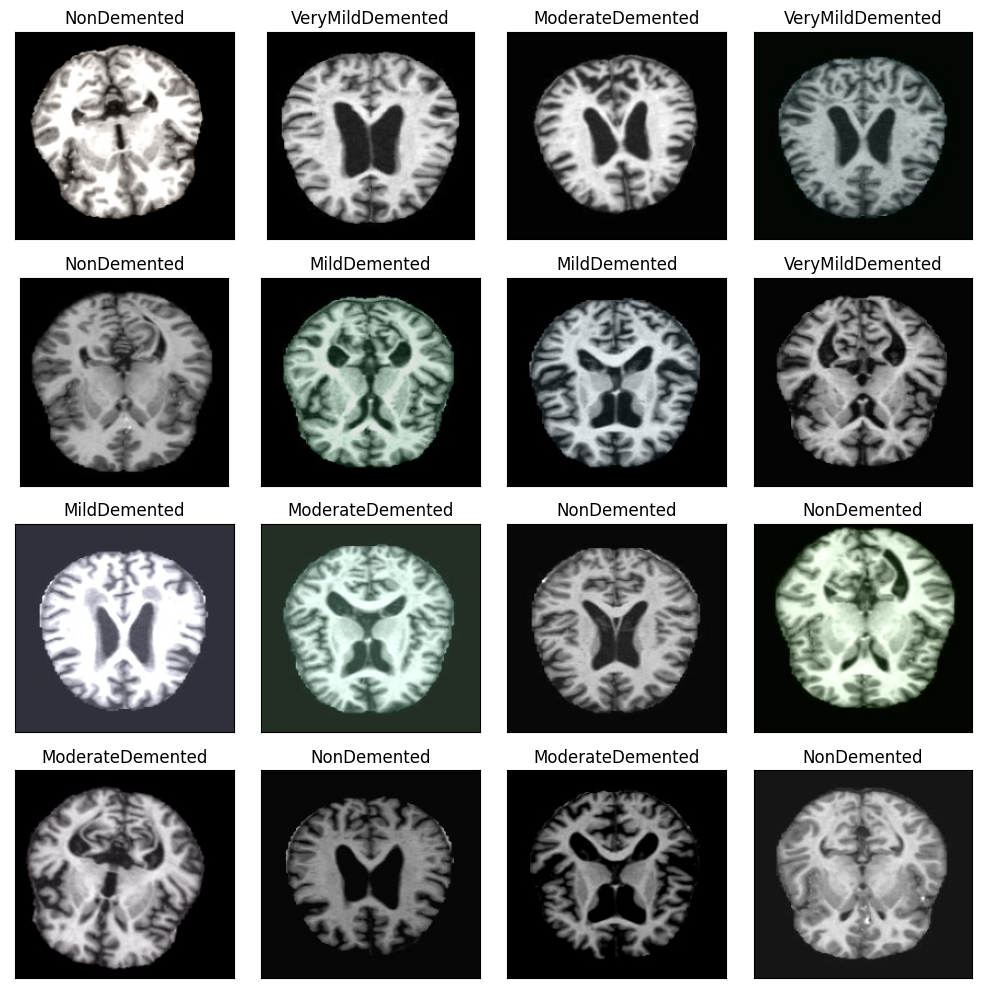

In [6]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()



In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2) # set validation split

train_images = train_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

validation_images = train_datagen.flow_from_directory(
    data , # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


In [8]:


inception_model = Sequential()

pretrained_model= tf.keras.applications.InceptionV3(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=4,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

inception_model.add(pretrained_model)



In [9]:
inception_model.add(Flatten())
inception_model.add(Dense(512, activation='relu'))
inception_model.add(Dropout(0.2))
inception_model.add(Dense(512, activation='relu'))
inception_model.add(Dropout(0.2))
inception_model.add(Dense(4, activation='softmax'))
inception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 22,853,924
Trainable params: 1,051,140
Non-trainable params: 21,802,784
_________________________________________________________________


In [17]:
inception_model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

history = inception_model.fit(train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=20)

Epoch 1/20
  2/850 [..............................] - ETA: 2:22 - loss: 0.5089 - accuracy: 0.7812 

KeyboardInterrupt: 

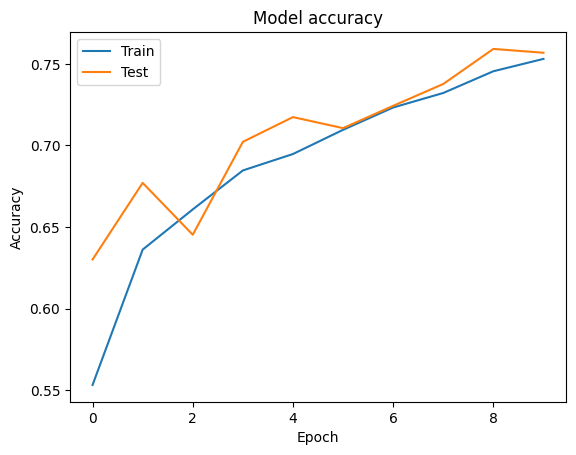

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')
